In [1]:
import sys
sys.path.append('/home/ivan/distribution_connector')
import os

In [2]:
from sklearn import datasets
import numpy as np
import torch
from tqdm import tqdm
from connector_utils import test_models, gather_statistics, test_func
import matplotlib.pyplot as plt

In [3]:
from connector import Connector
# from one_layer_utils import samples, make_dataset, get_model, get_b
from utils import test_model
from flows.models.utils import test_flow

# MNIST

In [4]:
import models
architecture = getattr(models, "LinearOneLayer") #LinearOneLayer LogRegression

import data
loaders, num_classes = data.loaders(
    "MNIST",
    "data",
    1024,
    1,
    "VGG",
    True)

model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)

model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve16/checkpoint-30.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve17/checkpoint-30.pt')['model_state'])

import pickle
data_path = '/home/ivan/dnn-mode-connectivity/data/MNIST.pickle'
with open(data_path, 'rb') as handle:
    dataset, B = pickle.load(handle)
b2 = torch.FloatTensor([np.array(B).mean(0)])
b = np.array(B).mean(0)

train_dataset, test_dataset = dataset[:-8000], dataset[-8000:]
modes = [dataset[-4000:-2000], dataset[-2000:]]

You are going to run models on the test set. Are you sure?


In [352]:
def samples(model):
    p = [list(model.parameters())[i].data.cpu().numpy() for i in range(len(list(model.parameters())))]
    return p

def samples_per_layer(model, bias=True):
    p = samples(model)
    if bias:
        p = [np.hstack([p[i], p[i+1][:, None]]) for i in range(0, len(p), 2)]        
    return p

def samples_butterfly(model, bias=True):
    if bias:
        return None
    else:   
        p = samples_per_layer(model, bias=bias)
        parameters = [np.hstack([p[i], p[i+1].T]) for i in range(0, len(p), 2)]
    return parameters

def get_model(W, architecture, bias=False, per_layer=True):
    model_sampled = architecture.base(num_classes=10, **architecture.kwargs)
    model_samples = np.array(W)  

    if per_layer:
        for parameter, w in zip(model_sampled.parameters(), W):
            parameter.data.copy_(torch.from_numpy(w))
    else:
        for i, parameter in enumerate(model_sampled.parameters()):
            w = W[i//2]
            if i % 2 == 0:
                offset = 0
            N = parameter.data.shape[1]
            w_part = w[:, offset:offset+N]
            offset = N
            if i % 2 == 0:
                parameter.data.copy_(torch.from_numpy(w_part))
            else:
                parameter.data.copy_(torch.from_numpy(w_part.T))
            

    return model_sampled

def get_model(W, B, architecture):
    model_sampled = architecture.base(num_classes=10, **architecture.kwargs)
    model_samples = np.array(W)  # .cpu().data.numpy()
    SIZE = model_sampled.middle_dim

    offset = 0
    for parameter in list(model_sampled.parameters())[:-1]:
        size = int(np.prod(parameter.size()) / SIZE)
        value = model_samples[:, offset:offset + size]
        if size == 10 or size == 1:
            value = value.T
        value = value.reshape(parameter.size())
        parameter.data.copy_(torch.from_numpy(value))
        offset += size

    list(model_sampled.parameters())[-1].data.copy_(B.mean(0))  # torch.from_numpy(

    return model_sampled

def samples(model):
    p1 = list(model.parameters())[0].data.cpu().numpy()
    p2 = list(model.parameters())[1].data.cpu().numpy()
    p3 = list(model.parameters())[2].transpose(0, 1).data.cpu().numpy()
    samples = np.hstack([p1, p2[:, None], p3])
    return samples

def transform(x1, x2, E12, E22_inv):
#     print(x1.shape, x2.shape, E12.shape, E22_inv.shape)
    y1 = x1 - E12 @ E22_inv @ x2
    return np.concatenate([y1, x2]).T
   
def inv_transform(y1, y2, E12, E22_inv):
#     print(x1.shape, x2.shape, E12.shape, E22_inv.shape)
    x1 = y1 + E12 @ E22_inv @ y2
    return np.concatenate([x1, y2]).T

In [353]:
parameters1 = samples(model1)
parameters2 = samples(model2)

S = np.vstack([parameters1, parameters2])

In [354]:
V2, sigma2 = find_PCA(parameters2.T)
V1, sigma1 = find_PCA(parameters1.T)
V, sigma = find_PCA(S.T)

In [355]:
sigma[:5]

array([0.01251369, 0.01229719, 0.01097456, 0.00997773, 0.00849614],
      dtype=float32)

In [356]:
parameters1 = parameters1@V.T*(1/np.sqrt(sigma+1e-8))
parameters2 = parameters2@V.T*(1/np.sqrt(sigma+1e-8))

In [357]:
# parameters1 = parameters1@V1.T*(1/np.sqrt(sigma1))
# parameters2 = parameters2@V2.T*(1/np.sqrt(sigma2))

In [358]:
(parameters1.T@parameters1)[0][:5]

array([1998.9954   ,   14.215335 ,  -20.863266 ,   -8.148998 ,
          2.8563523], dtype=float32)

In [359]:
(parameters2.T@parameters2)[0][:5]

array([2001.0015   ,  -14.215343 ,   20.863361 ,    8.148906 ,
         -2.8563156], dtype=float32)

In [360]:
from sklearn.decomposition import PCA, KernelPCA

def find_PCA(param):
    
#     U, s2, V = np.linalg.svd(param)
    cov = param@param.T/len(param.T)
    U, sigma, V = np.linalg.svd(cov)

    return V, sigma
#     transPSA = PCA(n_components=K, svd_solver='full', random_state=self.random_state)
#     S = transPSA.fit_transform(S)

In [361]:
# V = find_PCA(parameters1.T)

In [362]:
# parameters = 1/np.sqrt(2)*(parameters1+parameters2)

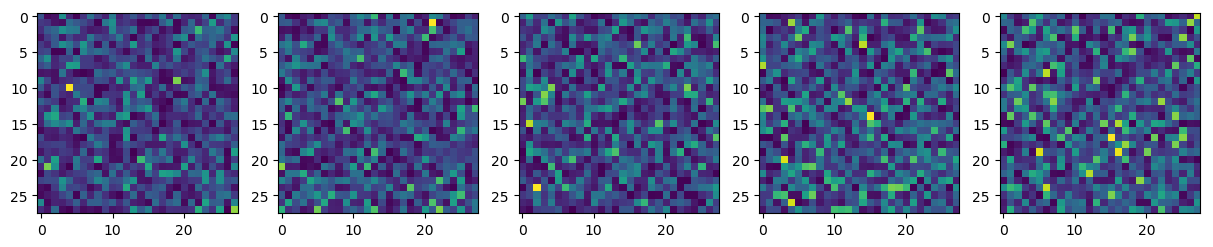

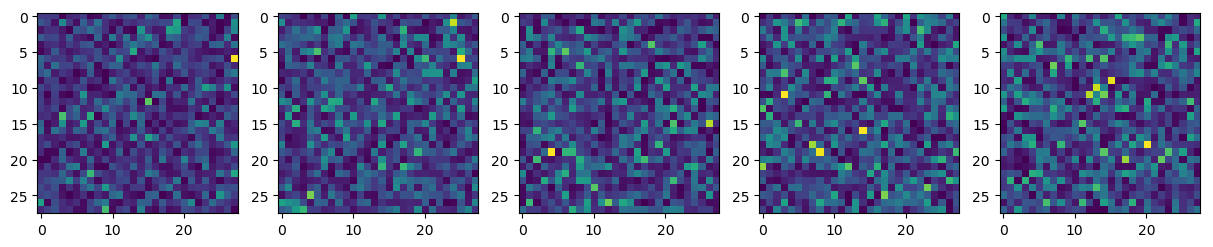

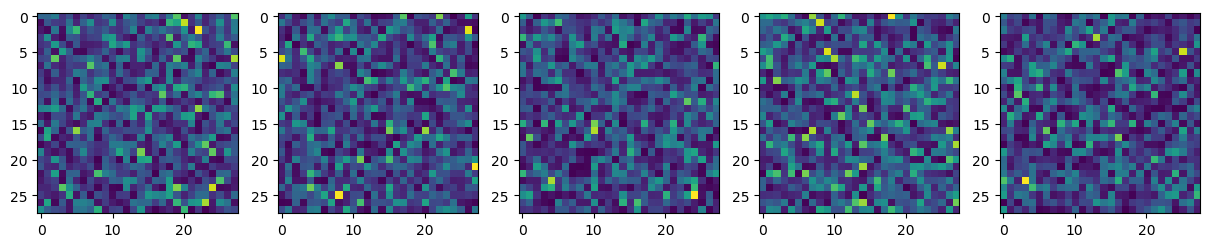

In [371]:
# parameters1 = samples(model1)
# parameters2 = samples(model2)

N = 5
from pylab import rcParams
fig, ax = plt.subplots(1, N)
rcParams['figure.figsize'] = 15, 15
rcParams['figure.dpi'] = 100
    
V1, sigma1 = find_PCA(parameters1.T)

for ind, im in enumerate(V1[:N, :784]):
    
    im = np.abs(im.reshape((28, 28)))
    ax[ind].imshow(im)
plt.show()

V2, sigma2 = find_PCA(parameters2.T)

fig, ax = plt.subplots(1, N)
rcParams['figure.figsize'] = 15, 15
rcParams['figure.dpi'] = 100

for ind, im in enumerate(V2[:N, :784]):
    
    im = np.abs(im.reshape((28, 28)))
    ax[ind].imshow(im)
plt.show()

fig, ax = plt.subplots(1, N)
rcParams['figure.figsize'] = 15, 15
rcParams['figure.dpi'] = 100

# V = 0.5*(V1+V2)
parameters = (parameters1+parameters2)*(1/2)
V_0, sigma_0 = find_PCA(parameters.T)

for ind, im in enumerate(V_0[:N, :784]):
    
    im = np.abs(im.reshape((28, 28)))
    ax[ind].imshow(im)
plt.show()

In [372]:
sigma1[:5], sigma2[:5], sigma_0[:5]

(array([1.7946018, 1.7877314, 1.7836329, 1.7772243, 1.7734181],
       dtype=float32),
 array([1.7946826, 1.786836 , 1.7816644, 1.7788498, 1.7764674],
       dtype=float32),
 array([0.8933073 , 0.89266866, 0.89163923, 0.8893695 , 0.8877665 ],
       dtype=float32))

In [373]:
parameters_check = parameters*2*np.sqrt(sigma+1e-8)@V

In [374]:
_, sigma_check = find_PCA(parameters_check.T)

In [375]:
_, sigma1 = find_PCA(parameters1.T)

In [376]:
sigma_check[:5], sigma1[:5]

(array([0.02551147, 0.02476173, 0.02196988, 0.02027021, 0.0173251 ],
       dtype=float32),
 array([1.7946018, 1.7877314, 1.7836329, 1.7772243, 1.7734181],
       dtype=float32))

In [377]:
# V[0]

In [378]:
model = get_model((parameters*np.sqrt(sigma+1e-8))@V, b2, architecture)
model.cuda();
model.eval();

test_model(model, loaders, cuda=True)

train results {'nll': 0.2635771894931793, 'loss': 0.2635771894931793, 'accuracy': 96.59666666666666}
test results {'nll': 0.2675380911827087, 'loss': 0.2675380911827087, 'accuracy': 95.82}


({'nll': 0.2635771894931793,
  'loss': 0.2635771894931793,
  'accuracy': 96.59666666666666},
 {'nll': 0.2675380911827087, 'loss': 0.2675380911827087, 'accuracy': 95.82})

In [96]:
def get_ev(model, index=0):
    W11 = list(model.parameters())[index].data.numpy()
    A = W11.T @ W11
    l, v = np.linalg.eig(A)
    v = np.real(v)
    l = np.real(l)
    return v, l
    

def heat_image(model):
    
    ev, e = get_ev(model)
    N = 5
    fig, ax = plt.subplots(1, N)
    
#     W11 = list(model.parameters())[0].data.numpy()
#     _, _, vh = np.linalg.svd(W11)
#     ev = vh.T @ ev
#     ev = ev>ev.mean()
    
    
    rcParams['figure.figsize'] = 15, 15
    rcParams['figure.dpi'] = 100
    
    for ind, (im, l) in enumerate(zip(ev.T[:N], e[:N])):
        im = np.abs(im.reshape((28, 28)))

        ax[ind].imshow(im)
        ax[ind].set_title(l)
        
#     plt.colorbar()
#     plt.axis('off')
    plt.show()

In [12]:
parameters1 = samples(model1)
parameters2 = samples(model2)

parameters = np.concatenate([parameters1, parameters2])

p = parameters - parameters.mean(0) 
cov = p.T @ p
E12 = cov[:-10, -10:]
E22 = cov[-10:, -10:]
E22_inv = np.linalg.inv(E22)

parameters1_tr = transform(parameters1[:, :-10].T, parameters1[:, -10:].T, E12,  E22_inv)
parameters2_tr = transform(parameters2[:, :-10].T, parameters2[:, -10:].T, E12,  E22_inv)

func = 'arc_connect'
print(func)
cntr = Connector(parameters1_tr, parameters2_tr)
f = getattr(cntr, func)
parameters_res = f()[1]

parameters_res_tr = inv_transform(parameters_res[:, :-10].T, parameters_res[:, -10:].T, E12,  E22_inv)

model = get_model(parameters_res_tr, b2, architecture)
model.cuda();
model.eval();
test_model(model, loaders, cuda=True)

arc_connect
train results {'nll': 0.07951138429244359, 'loss': 0.07951138429244359, 'accuracy': 98.015}
test results {'nll': 0.1023053573012352, 'loss': 0.1023053573012352, 'accuracy': 97.24}


({'nll': 0.07951138429244359, 'loss': 0.07951138429244359, 'accuracy': 98.015},
 {'nll': 0.1023053573012352, 'loss': 0.1023053573012352, 'accuracy': 97.24})

In [ ]:
model = get_model(parameters_res_tr, b2, architecture)
model.cuda();
model.eval();
test_model(model, loaders, cuda=True)

In [7]:
model1.cuda();
model1.eval();
test_model(model1, loaders, cuda=True)

train results {'nll': 0.039321160765488944, 'loss': 0.039321160765488944, 'accuracy': 99.13833333333334}
test results {'nll': 0.06698885906934739, 'loss': 0.06698885906934739, 'accuracy': 98.03}


({'nll': 0.039321160765488944,
  'loss': 0.039321160765488944,
  'accuracy': 99.13833333333334},
 {'nll': 0.06698885906934739, 'loss': 0.06698885906934739, 'accuracy': 98.03})

In [19]:
param1 = [parameters1[:, :-10].T, parameters1[:, -10:]]
param2 = [parameters2[:, :-10].T, parameters2[:, -10:]]

for func in ['lin_connect', 'arc_connect', 'arc_connect_PCA']:
    parameters_res = []
    print(func)
    for p1, p2 in zip(param1, param2):
        cntr = Connector(p1, p2)
        print(p1.shape)
        f = getattr(cntr, func)
        if 'PCA' in func:
            K = min(300, p1.shape[0], p1.shape[1])
            res = f(K=K)[1]
        elif 'third_cumulant' in func:
            K = min(100, p1.shape[0], p1.shape[1])
            res = f(K=K)[1] 
        else:
            res = f()[1]
            
        print('res', res.shape)
        parameters_res.append(res)
        
    parameters_res = np.hstack([parameters_res[0].T, parameters_res[1]])
    model = get_model(parameters_res, b2, architecture)
    model.cuda();
    model.eval();
    test_model(model, loaders, cuda=True)

lin_connect
(785, 2000)
res (785, 2000)
(2000, 10)
res (2000, 10)
train results {'nll': 0.263577197154363, 'loss': 0.263577197154363, 'accuracy': 96.59666666666666}
test results {'nll': 0.267538090467453, 'loss': 0.267538090467453, 'accuracy': 95.82}
arc_connect
(785, 2000)
res (785, 2000)
(2000, 10)
res (2000, 10)
train results {'nll': 0.08393143694798151, 'loss': 0.08393143694798151, 'accuracy': 97.68666666666667}
test results {'nll': 0.10656597929000855, 'loss': 0.10656597929000855, 'accuracy': 96.83}
arc_connect_PCA
(785, 2000)
res (785, 2000)
(2000, 10)
res (2000, 10)
train results {'nll': 0.0940992805838585, 'loss': 0.0940992805838585, 'accuracy': 97.27833333333334}
test results {'nll': 0.11312627819776536, 'loss': 0.11312627819776536, 'accuracy': 96.63}


In [10]:
func = 'arc_connect'
print(func)
cntr = Connector(parameters1_tr, parameters2_tr)
f = getattr(cntr, func)
parameters_res = f()[1]

arc_connect


In [149]:
parameters_res_tr = inv_transform(parameters_res[:, :-10].T, parameters_res[:, -10:].T, E12,  E22_inv)

In [151]:
model = get_model(parameters_res_tr, b2, architecture)
model.cuda();
model.eval();
test_model(model, loaders, cuda=True)

train results {'nll': 0.07982834839820861, 'loss': 0.07982834839820861, 'accuracy': 97.99666666666667}
test results {'nll': 0.10293639920949936, 'loss': 0.10293639920949936, 'accuracy': 97.14}


({'nll': 0.07982834839820861,
  'loss': 0.07982834839820861,
  'accuracy': 97.99666666666667},
 {'nll': 0.10293639920949936, 'loss': 0.10293639920949936, 'accuracy': 97.14})

In [79]:
# parameters_res_tr.shape

In [33]:
param_new = parameters1[:3]+parameters2[3:]

In [34]:
model = get_model(param_new, architecture, per_layer=True)
model.cuda();
model.eval();
test_model(model, loaders, cuda=True)

In [ ]:
for func in ['lin_connect', 'arc_connect', 'arc_connect_PCA']:
    parameters_res = []
    print(func)
    for p1, p2 in zip(parameters1, parameters2):
        cntr = Connector(p1, p2)
        f = getattr(cntr, func)
        if 'PCA' in func:
            K = min(300, p1.shape[0], p1.shape[1])
            res = f(K=K)[1]
        elif 'third_cumulant' in func:
            K = min(100, p1.shape[0], p1.shape[1])
            res = f(K=K)[1] 
        else:
            res = f()[1]
        parameters_res.append(res)

    model = get_model(parameters_res, architecture, per_layer=True)
    model.cuda();
    model.eval();
    test_model(model, loaders, cuda=True)

# MNIST PCA

In [6]:
# import models
# architecture = getattr(models, "LinearOneLayer") #LinearOneLayer LogRegression

# import data
# loaders, num_classes = data.loaders(
#     "MNIST",
#     "data",
#     1024,
#     1,
#     "VGG",
#     True)

# import pickle
# data_path = '/home/ivan/dnn-mode-connectivity/data/MNIST_PCA.pickle'
# with open(data_path, 'rb') as handle:
#     dataset, B, transformation = pickle.load(handle)
# b2 = torch.FloatTensor([np.array(B).mean(0)])
# b = np.array(B).mean(0)

# train_dataset, test_dataset = dataset[:-8000], dataset[-8000:]
# modes = [dataset[-4000:-2000], dataset[-2000:]]

In [7]:
test_dataset.shape

(8000, 795)

In [8]:
# from flows.models import RealNVP, RealNVP_OneLayer_full, IAF_OneLayer_full
# flow = RealNVP_OneLayer_full(in_dim=80, dim_middle=200, N_layers=5, batch_norm=False, data_b2=b, transPSA=transformation)
# flow.load_state_dict(torch.load('/home/ivan/distribution_connector/flow_models/RealNVP/MNIST_PCA_bijection3/checkpoint-2.pt')['model_state'])


In [9]:
# flow.cuda();
# test_flow(flow, architecture, loaders, b2, cntr=None, verbose=True,
#               test_sampling=True, test_flow=False, cuda=True, transPSA=transformation)

In [10]:
# flow.cuda();
# stat_dict, stat_dict_mean, stat_dict_std = gather_statistics(dataset[-8000:], 
#                                                              loaders, b2, architecture, 
#                                                              flow=flow, K=80, t=0.5, 
#                                                              verbose=True, func_name=['flow_connect'],
#                                                              save_stat=True, path='stat/MNIST/bijectionPCA',
#                                                              transPSA=transformation)

# Gavering sample and error time plots on MNIST

In [11]:
funcs = [func for func in dir(cntr) if callable(getattr(cntr, func)) and 'connect' in func 
         and 'flow' not in func and 'third_cumulant' not in func]

In [12]:
funcs

['arc_connect',
 'arc_connect_PCA',
 'inverse_connect',
 'inverse_connect_PCA',
 'lin_connect',
 'simul_diag_connect']

In [13]:
# for func_name in funcs:
#     t = np.linspace(0,1, 61)[1:-1]
#     stat = test_func(modes, loaders, b, architecture, func_name, flow=None, K=80, t=t, 
#                      show=False, verbose=False, save_pic=True, path='MNIST', save_samples=False,
#                      test_models=True, compute_distribution_stat=False, show_type='hex')
#     t = np.linspace(0,1, 5)[1:-1]
#     stat = test_func(modes, loaders, b, architecture, func_name, flow=None, K=80, t=t, 
#                      show=False, verbose=False, save_pic=False, path='MNIST', save_samples=True)
    

## flow 

In [14]:
# '/home/ivan/distribution_connector/flow_models/Flow_IAF/MNIST_flow/checkpoint-150.pt'
# from flows.models import RealNVP, RealNVP_OneLayer_full, IAF_OneLayer_full
# flow = IAF_OneLayer_full(in_dim=795, dim_middle=795, N_layers=2, batch_norm=False, data_b2=b)
# flow.load_state_dict(torch.load('/home/ivan/distribution_connector/flow_models/Flow_IAF/MNIST_flow/checkpoint-120.pt')['model_state'])


# flow.cuda();


In [17]:
from flows.models import RealNVP, RealNVP_OneLayer_full

flow = RealNVP_OneLayer_full(in_dim=795, dim_middle=2000, N_layers=1, batch_norm=True, data_b2=b)
flow.load_state_dict(torch.load('/home/ivan/distribution_connector/flow_models/RealNVP/MNIST_bijection/checkpoint-20.pt')['model_state'])
flow.cuda();


mask len 2


In [ ]:
t = np.linspace(0,1, 61)[1:-1]
stat = test_func(modes, loaders, b2, architecture, 'flow_connect', flow=flow, K=80, t=t, 
                     show=False, verbose=False, save_pic=True, path='MNIST', save_samples=False,
                     test_models=True, compute_distribution_stat=False, show_type='hex')

# Computing mean and std for different methods on MNIST

## flow 

In [36]:
# checkpoint-20.pt -- top for MNIST bijection
# checkpoint-7 top for CIFAR bijection
# checkpoint-120 top for MNIST Flow IAF 

In [61]:
# '/home/ivan/distribution_connector/flow_models/Flow_IAF/MNIST_flow/checkpoint-150.pt'
# from flows.models import RealNVP, RealNVP_OneLayer_full, IAF_OneLayer_full
# flow = IAF_OneLayer_full(in_dim=795, dim_middle=795, N_layers=2, batch_norm=False, data_b2=b)
# flow.load_state_dict(torch.load('/home/ivan/distribution_connector/flow_models/Flow_IAF/MNIST_flow/checkpoint-120.pt')['model_state'])





In [57]:
# from flows.models import RealNVP, RealNVP_OneLayer_full

# flow = RealNVP_OneLayer_full(in_dim=795, dim_middle=795, N_layers=1, batch_norm=True, data_b2=b)
# flow.load_state_dict(torch.load('/home/ivan/distribution_connector/flow_models/RealNVP/MNIST_flow1/checkpoint-8.pt')['model_state'])



In [58]:
# model = flow

In [59]:
# b = b2
# cuda = True
# verbose = True
# transPSA = None
# model.eval()
# res = model.sample(K=2000).cpu().data.numpy()
# if transPSA is not None:
#     res = transPSA.inverse_transform(res)
# m = get_model(res, b, architecture)
# if cuda:
#     m.cuda()
# result_s = test_model(m, loaders, verbose=verbose, cuda=cuda)

In [60]:
flow.cuda();
test_flow(flow, architecture, loaders, b2, cntr=None, verbose=True,
              test_sampling=True, test_flow=False, cuda=True, transPSA=None)

sampling testing
train results {'nll': 0.1873208567937215, 'loss': 0.1873208567937215, 'accuracy': 94.21833333333333}
test results {'nll': 0.19890189328193664, 'loss': 0.19890189328193664, 'accuracy': 94.02}


(({'nll': 0.1873208567937215,
   'loss': 0.1873208567937215,
   'accuracy': 94.21833333333333},
  {'nll': 0.19890189328193664,
   'loss': 0.19890189328193664,
   'accuracy': 94.02}),
 None)

In [62]:
# flow.cuda();
# stat_dict, stat_dict_mean, stat_dict_std = gather_statistics(dataset[-8000:], 
#                                                              loaders, b2, architecture, 
#                                                              flow=flow, K=80, t=0.5, 
#                                                              verbose=True, func_name=['flow_connect'],
#                                                              save_stat=True, path='stat/MNIST/IAFflow')

## basic 

In [17]:
test_dataset = dataset[-8000:]

In [18]:
funcs = [func for func in dir(cntr) if callable(getattr(cntr, func)) and 'connect' in func 
         and 'flow' not in func and 'third_cumulant' in func]

In [19]:
stat_dict, stat_dict_mean, stat_dict_std = gather_statistics(test_dataset, 
                                                             loaders, b2, architecture, 
                                                             flow=None, K=80, t=0.5, 
                                                             verbose=True, func_name=funcs,
                                                             save_stat=True, path='stat/MNIST/third_cumulant')


  0%|          | 0/4 [00:00<?, ?it/s]

N_models 4
third_cumulant_connect
c 1600.3411257129785 512000
0.5
train results {'nll': 0.8071608489990234, 'loss': 0.8071608489990234, 'accuracy': 75.44}
test results {'nll': 0.788148390865326, 'loss': 0.788148390865326, 'accuracy': 76.12}
third_cumulant_connect
c 1594.631502638252 512000
0.5
train results {'nll': 0.6341616157531739, 'loss': 0.6341616157531739, 'accuracy': 78.96333333333334}
test results {'nll': 0.6215544948577881, 'loss': 0.6215544948577881, 'accuracy': 79.51}
third_cumulant_connect
c 1602.5800297365204 512000
0.5



 25%|██▌       | 1/4 [01:37<04:51, 97.16s/it]

train results {'nll': 0.7839152718226114, 'loss': 0.7839152718226114, 'accuracy': 72.36}
test results {'nll': 0.7712775550842285, 'loss': 0.7712775550842285, 'accuracy': 72.52}
third_cumulant_connect
c 1601.0657202684679 512000
0.5
train results {'nll': 0.7509037694613139, 'loss': 0.7509037694613139, 'accuracy': 74.60666666666667}
test results {'nll': 0.7424520283699035, 'loss': 0.7424520283699035, 'accuracy': 74.86}
third_cumulant_connect
c 1617.6414617463297 512000
0.5



 50%|█████     | 2/4 [02:45<02:57, 88.53s/it]

train results {'nll': 0.8341048234621684, 'loss': 0.8341048234621684, 'accuracy': 73.07}
test results {'nll': 0.8145449273109436, 'loss': 0.8145449273109436, 'accuracy': 73.45}
third_cumulant_connect
c 1609.567649403868 512000
0.5



100%|██████████| 4/4 [03:20<00:00, 50.19s/it]

train results {'nll': 0.8697093101183574, 'loss': 0.8697093101183574, 'accuracy': 69.51166666666667}
test results {'nll': 0.8651455919265747, 'loss': 0.8651455919265747, 'accuracy': 69.71}
saving to  data/stat/MNIST/third_cumulanterror_stat.pickle


In [24]:
stat_dict_mean, stat_dict_std

({'train': {'arc_connect': 97.89348148148149,
   'arc_connect_PCA': 97.66703703703703,
   'inverse_connect': 97.84737037037036,
   'inverse_connect_PCA': 97.46407407407409,
   'lin_connect': 96.54114814814814,
   'simul_diag_connect': 97.84322222222224},
  'test': {'arc_connect': 97.03577777777775,
   'arc_connect_PCA': 97.02199999999999,
   'inverse_connect': 96.96955555555556,
   'inverse_connect_PCA': 96.81,
   'lin_connect': 95.87822222222223,
   'simul_diag_connect': 97.00844444444445}},
 {'train': {'arc_connect': 0.11143166107154394,
   'arc_connect_PCA': 0.09728974727356571,
   'inverse_connect': 0.13658556260530705,
   'inverse_connect_PCA': 0.11721224578692356,
   'lin_connect': 0.41123118700219913,
   'simul_diag_connect': 0.11861827977296019},
  'test': {'arc_connect': 0.14210307509205192,
   'arc_connect_PCA': 0.13511476603243608,
   'inverse_connect': 0.16937736377103318,
   'inverse_connect_PCA': 0.16152055252780917,
   'lin_connect': 0.40518467059348473,
   'simul_diag_c

# CIFAR10

In [21]:
import models
architecture = getattr(models, "LinearOneLayerCF") #LinearOneLayer LogRegression

import data
loaders, num_classes = data.loaders(
    "CIFAR10",
    "data",
    1024,
    1,
    "VGG",
    False)

model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)

model1.load_state_dict(torch.load('curves/LinearOneLayer/curve16/checkpoint-400.pt')['model_state'])
model2.load_state_dict(torch.load('curves/LinearOneLayer/curve17/checkpoint-400.pt')['model_state'])

import pickle
data_path = '/home/ivan/dnn-mode-connectivity/data/CIFAR.pickle'
with open(data_path, 'rb') as handle:
    dataset, B = pickle.load(handle)
b2 =  torch.FloatTensor([np.array(B).mean(0)])
b = np.array(B).mean(0)

train_dataset, test_dataset = dataset[:-8000], dataset[-8000:]
modes = [dataset[-4000:-2000], dataset[-2000:]]

Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified


In [22]:
parameters1 = samples(model1)
parameters2 = samples(model2)

parameters = np.concatenate([parameters1, parameters2])

cov = parameters.T @ parameters
E12 = cov[:-10, -10:]
E22 = cov[-10:, -10:]
E22_inv = np.linalg.inv(E22)

parameters1_tr = transform(parameters1[:, :-10].T, parameters1[:, -10:].T, E12,  E22_inv)
parameters2_tr = transform(parameters2[:, :-10].T, parameters2[:, -10:].T, E12,  E22_inv)

In [24]:
param1 = [parameters1[:, :-10], parameters1[:, -10:].T]
param2 = [parameters2[:, :-10], parameters2[:, -10:].T]

for func in ['lin_connect', 'arc_connect', 'arc_connect_PCA']:
    parameters_res = []
    print(func)
    for p1, p2 in zip(param1, param2):
        cntr = Connector(p1, p2)
        print(p1.shape)
        f = getattr(cntr, func)
        if 'PCA' in func:
            K = min(300, p1.shape[0], p1.shape[1])
            res = f(K=K)[1]
        elif 'third_cumulant' in func:
            K = min(100, p1.shape[0], p1.shape[1])
            res = f(K=K)[1] 
        else:
            res = f()[1]
            
        print('res', res.shape)
        parameters_res.append(res)
        
    parameters_res = np.hstack([parameters_res[0], parameters_res[1].T])
    model = get_model(parameters_res, b2, architecture)
    model.cuda();
    model.eval();
    test_model(model, loaders, cuda=True)

lin_connect
(2000, 3073)
res (2000, 3073)
(10, 2000)
res (10, 2000)
train results {'nll': 1.892354764175415, 'loss': 1.892354764175415, 'accuracy': 31.97}
test results {'nll': 2.0686955657958985, 'loss': 2.0686955657958985, 'accuracy': 37.79}
arc_connect
(2000, 3073)
res (2000, 3073)
(10, 2000)
res (10, 2000)
train results {'nll': 1.527513200187683, 'loss': 1.527513200187683, 'accuracy': 50.786}
test results {'nll': 2.882915619277954, 'loss': 2.882915619277954, 'accuracy': 40.65}
arc_connect_PCA
(2000, 3073)
res (2000, 3073)
(10, 2000)
res (10, 2000)
train results {'nll': 1.641271957511902, 'loss': 1.641271957511902, 'accuracy': 44.032}
test results {'nll': 2.6984750995635984, 'loss': 2.6984750995635984, 'accuracy': 37.42}


In [23]:
param1 = [parameters1[:, :-10], parameters1[:, -10:]]
param2 = [parameters2[:, :-10], parameters2[:, -10:]]

for func in ['lin_connect', 'arc_connect', 'arc_connect_PCA']:
    parameters_res = []
    print(func)
    for p1, p2 in zip(param1, param2):
        cntr = Connector(p1, p2)
        print(p1.shape)
        f = getattr(cntr, func)
        if 'PCA' in func:
            K = min(300, p1.shape[0], p1.shape[1])
            res = f(K=K)[1]
        elif 'third_cumulant' in func:
            K = min(100, p1.shape[0], p1.shape[1])
            res = f(K=K)[1] 
        else:
            res = f()[1]
            
        print('res', res.shape)
        parameters_res.append(res)
        
    parameters_res = np.hstack([parameters_res[0], parameters_res[1]])
    model = get_model(parameters_res, b2, architecture)
    model.cuda();
    model.eval();
    test_model(model, loaders, cuda=True)

lin_connect
(2000, 3073)
res (2000, 3073)
(2000, 10)
res (2000, 10)
train results {'nll': 1.8912518212890626, 'loss': 1.8912518212890626, 'accuracy': 32.088}
test results {'nll': 2.0686955657958985, 'loss': 2.0686955657958985, 'accuracy': 37.79}
arc_connect
(2000, 3073)
res (2000, 3073)
(2000, 10)
res (2000, 10)
train results {'nll': 1.4912290412139892, 'loss': 1.4912290412139892, 'accuracy': 50.816}
test results {'nll': 2.6923051845550536, 'loss': 2.6923051845550536, 'accuracy': 40.93}
arc_connect_PCA
(2000, 3073)
res (2000, 3073)
(2000, 10)
res (2000, 10)
train results {'nll': 1.4851501541519165, 'loss': 1.4851501541519165, 'accuracy': 51.288}
test results {'nll': 2.8195617031097413, 'loss': 2.8195617031097413, 'accuracy': 40.16}


In [15]:
param1 = [parameters1[:, :-10].T, parameters1[:, -10:]]
param2 = [parameters2[:, :-10].T, parameters2[:, -10:]]

for func in ['lin_connect', 'arc_connect', 'arc_connect_PCA']:
    parameters_res = []
    print(func)
    for p1, p2 in zip(param1, param2):
        cntr = Connector(p1, p2)
        print(p1.shape)
        f = getattr(cntr, func)
        if 'PCA' in func:
            K = min(300, p1.shape[0], p1.shape[1])
            res = f(K=K)[1]
        elif 'third_cumulant' in func:
            K = min(100, p1.shape[0], p1.shape[1])
            res = f(K=K)[1] 
        else:
            res = f()[1]
            
        print('res', res.shape)
        parameters_res.append(res)
        
    parameters_res = np.hstack([parameters_res[0].T, parameters_res[1]])
    model = get_model(parameters_res, b2, architecture)
    model.cuda();
    model.eval();
    test_model(model, loaders, cuda=True)

lin_connect
(3073, 2000)
res (3073, 2000)
(2000, 10)
res (2000, 10)
train results {'nll': 1.8950114845657349, 'loss': 1.8950114845657349, 'accuracy': 32.046}
test results {'nll': 2.0686955657958985, 'loss': 2.0686955657958985, 'accuracy': 37.79}
arc_connect
(3073, 2000)
res (3073, 2000)
(2000, 10)
res (2000, 10)
train results {'nll': 1.6132043946456909, 'loss': 1.6132043946456909, 'accuracy': 43.942}
test results {'nll': 2.6095668628692628, 'loss': 2.6095668628692628, 'accuracy': 41.38}
arc_connect_PCA
(3073, 2000)
res (3073, 2000)
(2000, 10)
res (2000, 10)
train results {'nll': 1.6867427646255493, 'loss': 1.6867427646255493, 'accuracy': 40.956}
test results {'nll': 2.651808978652954, 'loss': 2.651808978652954, 'accuracy': 40.74}


In [25]:
param1 = [parameters1[:, :-10].T, parameters1[:, -10:].T]
param2 = [parameters2[:, :-10].T, parameters2[:, -10:].T]

for func in ['lin_connect', 'arc_connect', 'arc_connect_PCA']:
    parameters_res = []
    print(func)
    for p1, p2 in zip(param1, param2):
        cntr = Connector(p1, p2)
        print(p1.shape)
        f = getattr(cntr, func)
        if 'PCA' in func:
            K = min(300, p1.shape[0], p1.shape[1])
            res = f(K=K)[1]
        elif 'third_cumulant' in func:
            K = min(100, p1.shape[0], p1.shape[1])
            res = f(K=K)[1] 
        else:
            res = f()[1]
            
        print('res', res.shape)
        parameters_res.append(res)
        
    parameters_res = np.hstack([parameters_res[0].T, parameters_res[1].T])
    model = get_model(parameters_res, b2, architecture)
    model.cuda();
    model.eval();
    test_model(model, loaders, cuda=True)

lin_connect
(3073, 2000)
res (3073, 2000)
(10, 2000)
res (10, 2000)
train results {'nll': 1.894404046974182, 'loss': 1.894404046974182, 'accuracy': 32.104}
test results {'nll': 2.0686955657958985, 'loss': 2.0686955657958985, 'accuracy': 37.79}
arc_connect
(3073, 2000)
res (3073, 2000)
(10, 2000)
res (10, 2000)
train results {'nll': 1.5941276955795287, 'loss': 1.5941276955795287, 'accuracy': 44.44}
test results {'nll': 2.962168966674805, 'loss': 2.962168966674805, 'accuracy': 41.61}
arc_connect_PCA
(3073, 2000)
res (3073, 2000)
(10, 2000)
res (10, 2000)
train results {'nll': 1.7525887490463257, 'loss': 1.7525887490463257, 'accuracy': 37.204}
test results {'nll': 2.861420792388916, 'loss': 2.861420792388916, 'accuracy': 37.24}


In [14]:
model1.cuda();
model1.eval();
test_model(model1, loaders, cuda=True)

train results {'nll': 0.8493014687347412, 'loss': 0.8493014687347412, 'accuracy': 70.424}
test results {'nll': 1.313883560180664, 'loss': 1.313883560180664, 'accuracy': 58.9}


({'nll': 0.8493014687347412, 'loss': 0.8493014687347412, 'accuracy': 70.424},
 {'nll': 1.313883560180664, 'loss': 1.313883560180664, 'accuracy': 58.9})

In [120]:
func = 'arc_connect'
parameters_res = []
print(func)
cntr = Connector(parameters1_tr, parameters2_tr)
f = getattr(cntr, func)
parameters_res = f()[1]

arc_connect


In [121]:
# parameters_res.shape

In [122]:
parameters_res_tr = inv_transform(parameters_res[:, :-10].T, parameters_res[:, -10:].T, E12,  E22_inv)

In [123]:
model = get_model(parameters_res_tr, b2, architecture)
model.cuda();
model.eval();
test_model(model, loaders, cuda=True)

train results {'nll': 1.4964728350067138, 'loss': 1.4964728350067138, 'accuracy': 51.208}
test results {'nll': 2.692305062484741, 'loss': 2.692305062484741, 'accuracy': 40.93}


({'nll': 1.4964728350067138, 'loss': 1.4964728350067138, 'accuracy': 51.208},
 {'nll': 2.692305062484741, 'loss': 2.692305062484741, 'accuracy': 40.93})

# Gavering sample and error time plots on CIFAR10

In [5]:
# for func_name in funcs:
#     t = np.linspace(0,1, 61)[1:-1]
#     stat = test_func(modes, loaders, b2, architecture, func_name, flow=None, K=400, t=t, 
#                      show=False, verbose=False, save_pic=True, path='CIFAR', save_samples=False)
#     t = np.linspace(0,1, 5)[1:-1]
#     stat = test_func(modes, loaders, b2, architecture, func_name, flow=None, K=400, t=t, 
#                      show=False, verbose=False, save_pic=False, path='CIFAR', save_samples=True)

## RNVP flow

In [6]:
# t = np.linspace(0,1, 61)[1:-1]
# stat = test_func(modes, loaders, b2, architecture, func_name='flow_connect', flow=flow, K=400, t=t, 
#                  show=False, verbose=False, save_pic=True, test_models=True, path='CIFAR', save_samples=False)

In [83]:
# t = np.linspace(0,1, 5)[1:-1]
# stat = test_func(modes, loaders, b2, architecture, func_name='flow_connect', flow=flow, K=400, t=t, 
#                  show=False, verbose=False, save_pic=False, path='CIFAR', save_samples=True)

# Computing mean and std for different methods on CIFAR10

In [14]:
model1.cuda()
test_model(model1, loaders, cuda=True)

train results {'nll': 0.8489676392555237, 'loss': 0.8489676392555237, 'accuracy': 70.572}
test results {'nll': 1.313883560180664, 'loss': 1.313883560180664, 'accuracy': 58.9}


({'nll': 0.8489676392555237, 'loss': 0.8489676392555237, 'accuracy': 70.572},
 {'nll': 1.313883560180664, 'loss': 1.313883560180664, 'accuracy': 58.9})

## flow

In [87]:
from flows.models import RealNVP, RealNVP_OneLayer_full, IAF_OneLayer_full

flow = RealNVP_OneLayer_full(in_dim=3083, dim_middle=3000, N_layers=1, batch_norm=False, data_b2=b)
flow.load_state_dict(torch.load('/home/ivan/distribution_connector/flow_models/RealNVP/CIFAR_test1/checkpoint-7.pt')['model_state'])


mask len 2


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [88]:
# from flows.models import RealNVP, RealNVP_OneLayer_full, IAF_OneLayer_full
# flow = IAF_OneLayer_full(in_dim=3083, dim_middle=3000, N_layers=1, batch_norm=False, data_b2=b)
# flow.load_state_dict(torch.load('/home/ivan/distribution_connector/flow_models/RealNVP/CIFAR_test1/checkpoint-7.pt')['model_state'])

In [89]:
flow.cuda();
stat_dict, stat_dict_mean, stat_dict_std = gather_statistics(dataset[-8000:], 
                                                             loaders, b2, architecture, 
                                                             flow=flow, K=80, t=0.5, 
                                                             verbose=True, func_name=['flow_connect'],
                                                             save_stat=True, path='stat/CIFAR/bijection')



  0%|          | 0/4 [00:00<?, ?it/s]

N_models 4
flow_connect
0.5
train results {'nll': 1.0533692544174194, 'loss': 1.0533692544174194, 'accuracy': 63.456}
test results {'nll': 1.6187260831832886, 'loss': 1.6187260831832886, 'accuracy': 53.59}
flow_connect
0.5
train results {'nll': 1.0545070586013794, 'loss': 1.0545070586013794, 'accuracy': 63.1}
test results {'nll': 1.7111023202896118, 'loss': 1.7111023202896118, 'accuracy': 52.64}
flow_connect
0.5




 25%|██▌       | 1/4 [01:00<03:01, 60.47s/it]

train results {'nll': 1.0488071635627747, 'loss': 1.0488071635627747, 'accuracy': 63.788}
test results {'nll': 1.5592954841613769, 'loss': 1.5592954841613769, 'accuracy': 55.26}
flow_connect
0.5
train results {'nll': 1.0633495126342773, 'loss': 1.0633495126342773, 'accuracy': 63.462}
test results {'nll': 1.5593252670288087, 'loss': 1.5593252670288087, 'accuracy': 54.64}
flow_connect
0.5




 50%|█████     | 2/4 [01:41<01:49, 54.79s/it]

train results {'nll': 1.0475879463577271, 'loss': 1.0475879463577271, 'accuracy': 63.818}
test results {'nll': 1.5472380882263184, 'loss': 1.5472380882263184, 'accuracy': 54.58}
flow_connect
0.5




 75%|███████▌  | 3/4 [02:03<00:44, 44.90s/it]

100%|██████████| 4/4 [02:03<00:00, 30.96s/it]

train results {'nll': 1.0577251321029664, 'loss': 1.0577251321029664, 'accuracy': 63.144}
test results {'nll': 1.6692164546966552, 'loss': 1.6692164546966552, 'accuracy': 52.93}
saving to  data/stat/CIFAR/bijectionerror_stat.pickle


## basic 

In [7]:
test_dataset = dataset[-8000:]

In [11]:
funcs = [func for func in dir(cntr) if callable(getattr(cntr, func)) and 'connect' in func 
         and 'flow' not in func and 'third_cumulant' in func]

In [12]:
funcs

['third_cumulant_connect']

In [14]:
stat_dict, stat_dict_mean, stat_dict_std = gather_statistics(test_dataset, 
                                                             loaders, b2, architecture, 
                                                             flow=None, K=200, t=0.5, 
                                                             verbose=True, func_name=funcs,
                                                             save_stat=True, path='stat/CIFAR/third_cumulant')


  0%|          | 0/4 [00:00<?, ?it/s]

N_models 4
third_cumulant_connect
c 49339.753945420765 8000000
0.5
train results {'nll': 192.03328536132813, 'loss': 192.03328536132813, 'accuracy': 10.95}
test results {'nll': 159.18884404296875, 'loss': 159.18884404296875, 'accuracy': 11.4}
third_cumulant_connect
c 49147.18525962689 8000000
0.5
train results {'nll': 197.92421240234376, 'loss': 197.92421240234376, 'accuracy': 10.81}
test results {'nll': 172.68769267578125, 'loss': 172.68769267578125, 'accuracy': 11.54}
third_cumulant_connect
c 49338.789716830164 8000000
0.5



 25%|██▌       | 1/4 [19:02<57:07, 1142.60s/it]

train results {'nll': 200.2789377734375, 'loss': 200.2789377734375, 'accuracy': 11.184}
test results {'nll': 174.5269504638672, 'loss': 174.5269504638672, 'accuracy': 12.38}
third_cumulant_connect
c 49031.59461684667 8000000
0.5
train results {'nll': 196.78189912109374, 'loss': 196.78189912109374, 'accuracy': 10.758}
test results {'nll': 166.34349104003905, 'loss': 166.34349104003905, 'accuracy': 11.96}
third_cumulant_connect
c 49216.40067193843 8000000
0.5



 50%|█████     | 2/4 [32:55<34:59, 1049.84s/it]

train results {'nll': 203.76456399902344, 'loss': 203.76456399902344, 'accuracy': 10.178}
test results {'nll': 165.93680776367188, 'loss': 165.93680776367188, 'accuracy': 11.31}
third_cumulant_connect
c 49634.76412962114 8000000
0.5



100%|██████████| 4/4 [39:04<00:00, 586.23s/it]

train results {'nll': 204.2034564892578, 'loss': 204.2034564892578, 'accuracy': 10.938}
test results {'nll': 168.1272219970703, 'loss': 168.1272219970703, 'accuracy': 12.78}
saving to  data/stat/CIFAR/third_cumulanterror_stat.pickle


# Checking

In [23]:
with open('data/stat/CIFAR/third_cumulanterror_stat.pickle', 'rb') as handle:
        load = pickle.load(handle)

In [24]:
load[1]

{'train': {'third_cumulant_connect': 10.802999999999999},
 'test': {'third_cumulant_connect': 11.895000000000001}}

In [25]:
load[2]

{'train': {'third_cumulant_connect': 0.31029394665918486},
 'test': {'third_cumulant_connect': 0.5378893938348291}}

In [26]:
stat_dict_mean, stat_dict_std

({'train': {'flow_connect': 63.60966666666667},
  'test': {'flow_connect': 53.94}},
 {'train': {'flow_connect': 0.353156087618808},
  'test': {'flow_connect': 0.9552137631615929}})